
# SVM 与 SMO 算法详解（支持公式渲染）

## 一、SVM（支持向量机）简介

支持向量机（Support Vector Machine, SVM）是一种二分类模型，其基本思想是寻找一个最优超平面，使其能够最大间隔地将样本划分为两类。

### 1.1 问题形式（线性可分）

给定训练数据集：

$$
\{(x_1, y_1), (x_2, y_2), ..., (x_m, y_m)\}, \quad x_i \in \mathbb{R}^n, \quad y_i \in \{-1, +1\}
$$

目标是找到一个超平面 $w^T x + b = 0$，使得正负样本被正确分类，并且间隔最大。

目标函数：

$$
\min_{w, b} \frac{1}{2} \|w\|^2
$$

约束条件：

$$
y_i (w^T x_i + b) \geq 1, \quad i = 1, ..., m
$$

---

## 二、从原始问题到对偶问题的推导

### 2.1 拉格朗日对偶形式

引入拉格朗日乘子 $\alpha_i$，构造拉格朗日函数：

$$
L(w, b, \alpha) = \frac{1}{2} \|w\|^2 - \sum_{i=1}^m \alpha_i [y_i (w^T x_i + b) - 1]
$$

对 $w$ 和 $b$ 分别求导并令其为 0：

- $\frac{\partial L}{\partial w} = 0 \Rightarrow w = \sum_{i=1}^m \alpha_i y_i x_i$
- $\frac{\partial L}{\partial b} = 0 \Rightarrow \sum_{i=1}^m \alpha_i y_i = 0$

我们带回 $w$ 是为了把原始优化问题转化成更易求解的对偶问题；而对偶问题是一个等价的、只涉及拉格朗日乘子 $\alpha$ 的优化问题。

我们将 $w = \sum \alpha_i y_i x_i$ 代入原始拉格朗日函数 $L(w, b, \alpha)$ 中，得到对偶形式：

### 2.2 对偶问题形式（Dual Form）

$$
\max_{\alpha} \quad W(\alpha) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha_i \alpha_j y_i y_j x_i^T x_j
$$

约束条件：

$$
\sum_{i=1}^m \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C
$$

---

## 三、SMO（序列最小优化）算法简介

SMO（Sequential Minimal Optimization）是 John C. Platt 提出的用于高效求解上述 SVM 对偶问题的算法。其基本思想是每次选择两个变量 $\alpha_i$ 和 $\alpha_j$ 进行优化，其余变量保持不变。

---

## 四、SMO 公式推导详解

### 4.1 简化目标函数

由于每次只更新两个变量 $\alpha_i$ 和 $\alpha_j$，其余固定，可以将对偶目标函数简化为：

$$
W(\alpha_i, \alpha_j) = \alpha_i + \alpha_j - \frac{1}{2} \left( K_{ii} \alpha_i^2 + K_{jj} \alpha_j^2 + 2 y_i y_j K_{ij} \alpha_i \alpha_j \right) + \text{const}
$$

其中 $K_{ij} = x_i^T x_j$ 是核函数的结果。

### 4.2 更新公式推导

定义误差：

$$
E_i = f(x_i) - y_i
$$

定义：

$$
\eta = K_{ii} + K_{jj} - 2K_{ij}
$$

更新公式如下：

$$
\alpha_j^{new} = \alpha_j^{old} + \frac{y_j (E_i - E_j)}{\eta}
$$

更新 $\alpha_i$：

$$
\alpha_i^{new} = \alpha_i^{old} + y_i y_j (\alpha_j^{old} - \alpha_j^{new})
$$

对 $\alpha_j^{new}$ 进行裁剪，限制在区间 $[L, H]$ 内：

```python
if y[i] == y[j]:
    lower = max(0, zeta / y[i] - C)
    upper = min(C, zeta / y[i])
else:
    lower = max(0, zeta / y[i])
    upper = min(C, zeta / y[i] + C)

alpha_j = np.clip(alpha_j, lower, upper)
```

---

## 五、SMO 算法流程总结

1. 初始化所有 $\alpha_i = 0$，$b = 0$
2. 在不满足 KKT 条件的样本中选择一对 $\alpha_i, \alpha_j$
3. 更新 $\alpha_i$、$\alpha_j$ 和 $b$
4. 重复步骤 2-3，直到所有样本满足 KKT 条件或达到迭代上限

---

## 六、模型参数的计算（$w$ 和 $b$ 的求解）

### 6.1 支持向量的判定

```python
sup_idx = alpha > 1e-5
```

$$
\text{支持向量} \iff \alpha_i > 10^{-5}
$$

### 6.2 计算权重向量 $w$

```python
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
```

$$
w = \sum_{i \in \text{SV}} \alpha_i y_i x_i
$$

### 6.3 计算偏置 $b$

```python
wx = x @ w.reshape(-1, 1)
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1]))
```

$$
b = -\frac{1}{2} \left( \max_{y_i = -1} w^T x_i + \min_{y_i = +1} w^T x_i \right)
$$

### 6.4 模型输出

```python
print('支持向量个数：', np.sum(sup_idx))
print('参数：', w, b)
```


数据集大小: 200


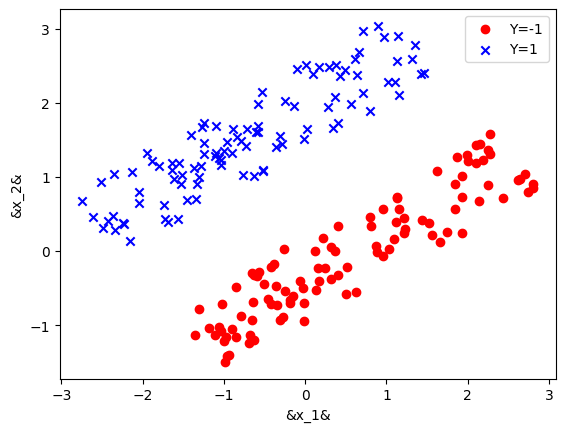

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm,trange

data=np.loadtxt('linear.csv',delimiter=',')
print("数据集大小:",len(data))

x=data[:,:2]
y=data[:,2]

#数据集可视化
plt.figure()
plt.scatter(x[y==-1,0],x[y==-1,1],color='red',label='Y=-1')
plt.scatter(x[y==1,0],x[y==1,1],color='blue',marker='x',label='Y=1')
plt.xlabel(r'&x_1&')
plt.ylabel(r'&x_2&')
plt.legend()
plt.show()


### SMO
#### 参数
  - x,y 样本的值和类别
  - ker 核函数，与线性回归中的核函数的含义相同
  - C惩罚系数
  - nax_iter 迭代次数

In [ ]:
def SMO(x,y,ker,C,max_iter):
    
    m=x.shape[0]
    alpha=np.zeros(m)
    #我们先把每一个向量的内积先计算出来
    K=np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            K[i,j]=ker(x[i],x[j])
    
    #开始迭代
    for l in trange(max_iter):  #trange是tqdm的功能，相当于range加了一个进度条的功能
        for i in range(m):
            #先固定 i 然后随机一个j出来，并且保证 i!=j
            j=np.random.choice([l for l in range(m) if l!=i])

            #用 -q/2p代替alpha_i的值   简化版
            eta=K[i,i]+K[j,j]-2*K[i,j]
            e_i=np.sum(y*alpha*K[:,i])-y[i]  #这个就是简化公式中的 g(x_i)-y_i
            e_j=np.sum(y*alpha*K[:,j])-y[j]  # g(x_j)-y_j
            #更新alpha_i
            alpha_i=alpha[i]+y[i]*(e_j-e_i)/(eta+1e-5)  # 防止除以0
            zeta=alpha[i]*y[i]+alpha[j]*y[j]  #这个就是限制条件  

            #将alpha_i和对应的alpha_j保持再[0,C]区间
            # alpha_i=(zeta - y_j * alpha_j)/y_i
            # alpha_h=(zeta - y_i * alpha_i)/y_j
            #0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i]==y[j]:                      #即 zeta/y[i]=alpha_i+alpha_j
                lower=max(0,zeta/y[i]-C)     #不能小到导致 alpha_j>C，
                upper=min(C,zeta/y[i])       #不能大到导致 alpha_j<0
            else:
                lower=max(0,zeta/y[i])
                upper=min(C,zeta/y[i]+C)
            #更新alpha_i,alpha_j    
            alpha_i=np.clip(alpha_i,lower,upper)  #将数组中的每个元素限制在指定的范围 [a_min, a_max] 内，超出范围的会被“裁剪”掉。 如果是单个数字，就取边界值 
            alpha_j=(zeta-y[i]*alpha_i)/y[j]

            #更新alpha
            alpha[i],alpha[j]=alpha_i,alpha_j

    return alpha

In [11]:
# 设置超参数
C = 1e8 # 由于数据集完全线性可分，我们不引入松弛变量
max_iter = 1000

np.random.seed(0)

alpha = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

100%|██████████| 1000/1000 [00:07<00:00, 139.31it/s]


支持向量个数： 6
参数： [-1.0211867   1.66445549] -1.312702097039547


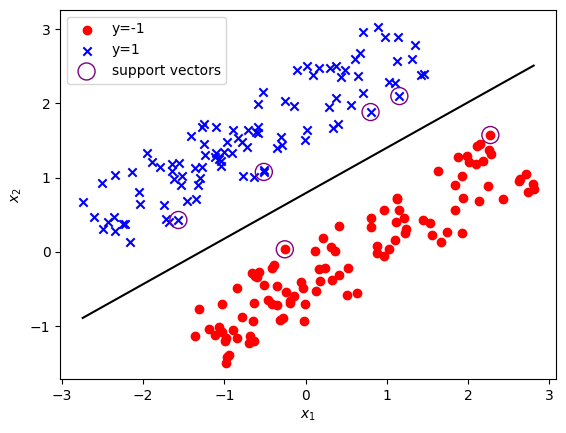

In [12]:
# 用alpha计算w，b和支持向量
sup_idx = alpha > 1e-5 # 支持向量的系数不为零
print('支持向量个数：', np.sum(sup_idx))
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
wx = x @ w.reshape(-1, 1)
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1]))
print('参数：', w, b)

# 绘图
X = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
Y = -(w[0] * X + b) / (w[1] + 1e-5)
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.plot(X, Y, color='black')
# 用圆圈标记出支持向量
plt.scatter(x[sup_idx, 0], x[sup_idx, 1], marker='o', color='none', 
    edgecolor='purple', s=150, label='support vectors')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()